# Posterior Distributions for  AR(1) Parameters

We'll begin with some Python imports.

In [1]:
!pip install arviz pymc numpyro jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/590.2 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.2/590.2 kB 13.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 kB 39.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 9.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.4 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.0 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 8.2 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 done


 \

 done


  Created wheel for cons: filename=cons-0.4.5-py3-none-any.whl size=9114 sha256=ab196bf2e86facbfff214e677cbe05a387e12c38cbd51c82809841f1d5cbfe60
  Stored in directory: /github/home/.cache/pip/wheels/df/1c/d4/98d11d61a5a6c5de77e96de4aa2568cba4b8a4379854728e20


 \

 done
  Created wheel for logical-unification: filename=logical_unification-0.4.5-py3-none-any.whl size=13754 sha256=d40b2b73ddbdf2881f738bfb0eb0b2731c1fe428d0a81108f5bfe1ec3f66cf00
  Stored in directory: /github/home/.cache/pip/wheels/f9/ec/f8/17a976d5963719c370a62cab7de82bd2719c660ccd91495898


 \

 done


  Created wheel for etuples: filename=etuples-0.3.8-py3-none-any.whl size=12616 sha256=0a61acb90c9c155ef2ba82b08c9a00109ee6635e7b65c5eda49240a4803cd7fd
  Stored in directory: /github/home/.cache/pip/wheels/1c/8c/c2/706794a2b015baed544654916ae048e78517b1058a957297bf


 \

 done
  Created wheel for miniKanren: filename=miniKanren-1.0.3-py3-none-any.whl size=23909 sha256=2d6fbcbccac5580521d9f4ca11b85bcf4704f35316bbb7777ce8540a3e1ac6a4
  Stored in directory: /github/home/.cache/pip/wheels/d3/a4/be/da3156a6e79d4ce54e83d66e27510361fce41bec9bd174b288
Successfully built cons logical-unification etuples miniKanren


In [2]:
import arviz as az
import pymc as pmc
import numpyro
from numpyro import distributions as dist

import numpy as np
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

%matplotlib inline

import logging
logging.basicConfig()
logger = logging.getLogger('pymc')
logger.setLevel(logging.CRITICAL)


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This lecture uses Bayesian methods offered by [pymc](https://www.pymc.io/projects/docs/en/stable/) and [numpyro](https://num.pyro.ai/en/stable/) to make statistical inferences about two parameters of a univariate first-order autoregression.


The model is a good laboratory for illustrating
consequences of alternative ways of modeling the distribution of the initial  $y_0$:

- As a fixed number

- As a random variable drawn from the stationary distribution of the $\{y_t\}$ stochastic process


The first component of the statistical model is

$$
y_{t+1} = \rho y_t + \sigma_x \epsilon_{t+1}, \quad t \geq 0
$$ (eq:themodel)

where the scalars $\rho$ and $\sigma_x$ satisfy $|\rho| < 1$ and $\sigma_x > 0$;
$\{\epsilon_{t+1}\}$ is a sequence of i.i.d. normal random variables with mean $0$ and variance $1$.

The second component of the statistical model is

$$
y_0 \sim {\cal N}(\mu_0, \sigma_0^2)
$$ (eq:themodel_2)



Consider a sample $\{y_t\}_{t=0}^T$ governed by this statistical model.  

The model
implies that the likelihood function of $\{y_t\}_{t=0}^T$ can be **factored**:

$$
f(y_T, y_{T-1}, \ldots, y_0) = f(y_T| y_{T-1}) f(y_{T-1}| y_{T-2}) \cdots f(y_1 | y_0 ) f(y_0)
$$

where we use $f$ to denote a generic probability density.  

The  statistical model {eq}`eq:themodel`-{eq}`eq:themodel_2` implies

$$
\begin{aligned}
f(y_t | y_{t-1})  & \sim {\mathcal N}(\rho y_{t-1}, \sigma_x^2) \\
        f(y_0)  & \sim {\mathcal N}(\mu_0, \sigma_0^2)
\end{aligned}
$$

We want to study how inferences about the unknown parameters $(\rho, \sigma_x)$ depend on what is assumed about the parameters $\mu_0, \sigma_0$  of the distribution of $y_0$.

Below, we study two widely used alternative assumptions:

-  $(\mu_0,\sigma_0) = (y_0, 0)$ which means  that $y_0$ is  drawn from the distribution ${\mathcal N}(y_0, 0)$; in effect, we are **conditioning on an observed initial value**.  

-  $\mu_0,\sigma_0$ are functions of $\rho, \sigma_x$ because $y_0$ is drawn from the stationary distribution implied by $\rho, \sigma_x$.



**Note:** We do **not** treat a third possible case in which  $\mu_0,\sigma_0$ are free parameters to be estimated.

Unknown parameters are $\rho, \sigma_x$.

We have  independent **prior probability distributions** for $\rho, \sigma_x$ and want to compute a posterior probability distribution after observing a sample $\{y_{t}\}_{t=0}^T$.  

The notebook uses `pymc4` and `numpyro` to compute a posterior distribution of $\rho, \sigma_x$. We will use NUTS samplers to generate samples from the posterior in a chain. Both of these libraries support NUTS samplers.

NUTS is a form of Monte Carlo Markov Chain (MCMC) algorithm that bypasses random walk behaviour and allows for convergence to a target distribution more quickly. This not only has the advantage of speed, but allows for complex models to be fitted without having to employ specialised knowledge regarding the theory underlying those fitting methods.

Thus, we explore consequences of making these alternative assumptions about the distribution of $y_0$:

- A first procedure is to condition on whatever value of $y_0$ is observed. This amounts to assuming that the probability distribution of the random variable  $y_0$ is a Dirac delta function that puts probability one on the observed value of $y_0$.    

- A second procedure  assumes that $y_0$ is drawn from the stationary distribution of a process described by {eq}`eq:themodel`
so that  $y_0 \sim {\cal N} \left(0, {\sigma_x^2\over (1-\rho)^2} \right) $

When the initial value $y_0$ is far out in a tail of the stationary distribution, conditioning on an initial value gives a posterior that is **more accurate** in a sense that we'll explain.   

Basically, when $y_0$ happens to be  in a tail of the stationary distribution and we **don't condition on $y_0$**, the likelihood function for $\{y_t\}_{t=0}^T$ adjusts the posterior distribution of the parameter pair $\rho, \sigma_x $ to make the observed value of $y_0$  more likely than it really is under the stationary distribution, thereby adversely twisting the posterior in short samples.

An example below shows how not conditioning on $y_0$ adversely shifts the posterior probability distribution of $\rho$ toward larger values.


We begin by solving a **direct problem** that simulates an AR(1) process.

How we select the initial value $y_0$ matters.

   * If we think $y_0$ is drawn from the stationary distribution ${\mathcal N}(0, \frac{\sigma_x^{2}}{1-\rho^2})$, then it is a good idea to use this distribution as $f(y_0)$.  Why? Because $y_0$ contains information about $\rho, \sigma_x$.  

   * If we suspect that $y_0$ is far in the tails of the stationary distribution -- so that variation in early observations in the sample have a significant **transient component** -- it is better to condition on $y_0$ by setting $f(y_0) = 1$.


To illustrate the issue, we'll begin by choosing an initial $y_0$ that is far out in a tail of the stationary distribution.

In [3]:
def ar1_simulate(rho, sigma, y0, T):

    # Allocate space and draw epsilons
    y = np.empty(T)
    eps = np.random.normal(0.,sigma,T)

    # Initial condition and step forward
    y[0] = y0
    for t in range(1, T):
        y[t] = rho*y[t-1] + eps[t]

    return y

sigma =  1.
rho = 0.5
T = 50

np.random.seed(145353452)
y = ar1_simulate(rho, sigma, 10, T)

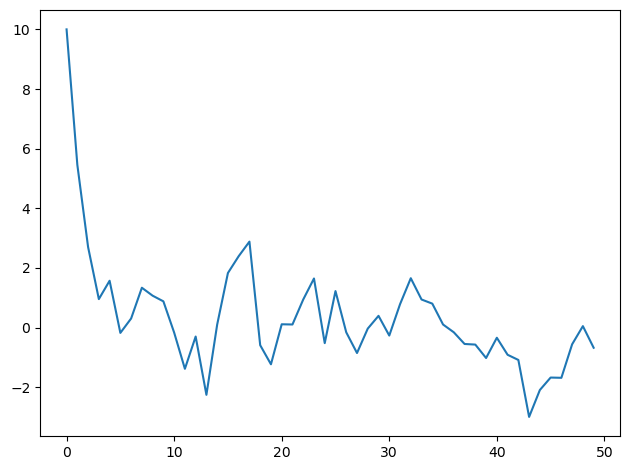

In [4]:
plt.plot(y)
plt.tight_layout()

Now we shall use Bayes' law to construct a posterior distribution, conditioning on the initial value of $y_0$.

(Later we'll assume that $y_0$ is drawn from the stationary distribution, but not now.)

First we'll use **pymc4**.

## PyMC Implementation

For a normal distribution in `pymc`,
$var = 1/\tau = \sigma^{2}$.

In [5]:
AR1_model = pmc.Model()

with AR1_model:

    # Start with priors
    rho = pmc.Uniform('rho', lower=-1., upper=1.) # Assume stable rho
    sigma = pmc.HalfNormal('sigma', sigma = np.sqrt(10))

    # Expected value of y at the next period (rho * y)
    yhat = rho * y[:-1]

    # Likelihood of the actual realization
    y_like = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=y[1:])

[pmc.sample](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.sample.html?highlight=sample#pymc.sample) by default uses the NUTS samplers to generate samples as shown in the below cell:

In [6]:
with AR1_model:
    trace = pmc.sample(50000, tune=10000, return_inferencedata=True)

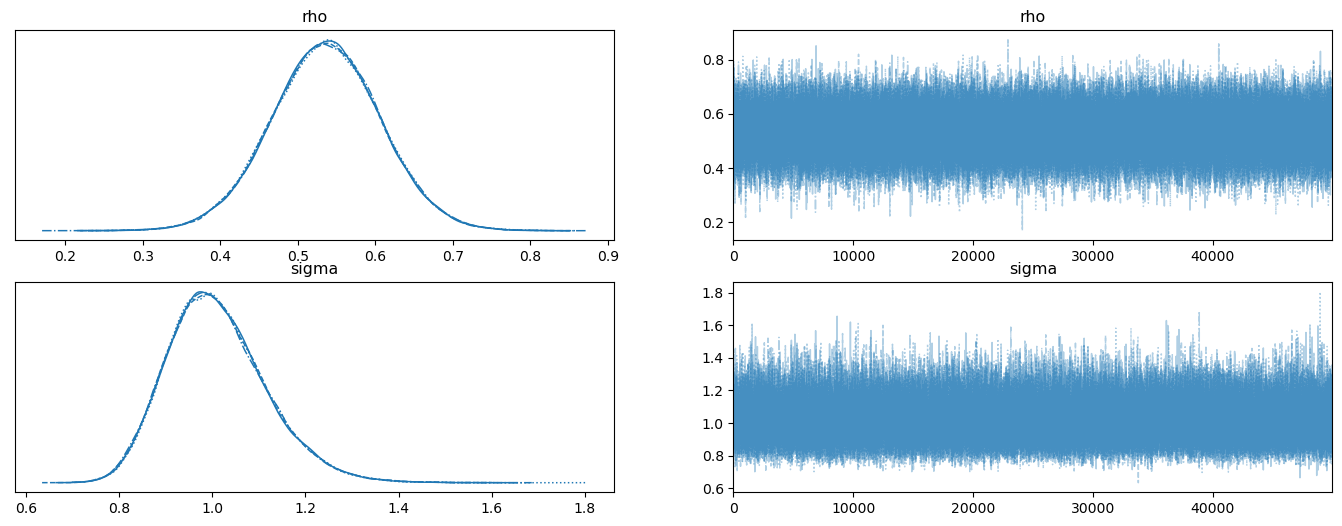

In [7]:
with AR1_model:
    az.plot_trace(trace, figsize=(17,6))

Evidently, the posteriors aren't centered on the true values of $.5, 1$ that we used to generate the data.

This is a symptom of the classic **Hurwicz bias** for first order autoregressive processes (see Leonid Hurwicz {cite}`hurwicz1950least`.)

The Hurwicz bias is worse the smaller is the sample (see {cite}`Orcutt_Winokur_69`).


Be that as it may, here is more information about the posterior.

In [8]:
with AR1_model:
    summary = az.summary(trace, round_to=4)

summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.5362,0.0707,0.4018,0.6688,0.0002,0.0001,176027.3823,124941.5095,1.0
sigma,1.0100,0.1068,0.8193,1.2137,0.0003,0.0002,177188.7216,138614.7408,1.0


Now we shall compute a posterior distribution after seeing the same data but instead assuming that $y_0$ is drawn from the stationary distribution.

This means that

$$
y_0 \sim N \left(0, \frac{\sigma_x^{2}}{1 - \rho^{2}} \right)
$$

We alter the code as follows:

In [9]:
AR1_model_y0 = pmc.Model()

with AR1_model_y0:

    # Start with priors
    rho = pmc.Uniform('rho', lower=-1., upper=1.) # Assume stable rho
    sigma = pmc.HalfNormal('sigma', sigma=np.sqrt(10))

    # Standard deviation of ergodic y
    y_sd = sigma / np.sqrt(1 - rho**2)

    # yhat
    yhat = rho * y[:-1]
    y_data = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=y[1:])
    y0_data = pmc.Normal('y0_obs', mu=0., sigma=y_sd, observed=y[0])

In [10]:
with AR1_model_y0:
    trace_y0 = pmc.sample(50000, tune=10000, return_inferencedata=True)

# Grey vertical lines are the cases of divergence

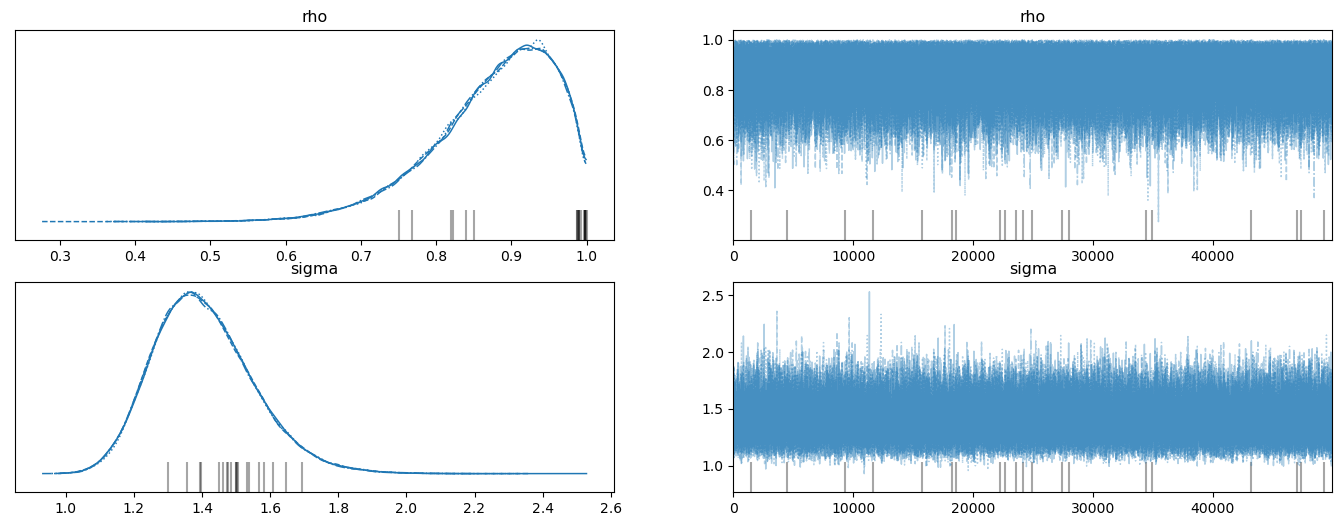

In [11]:
with AR1_model_y0:
    az.plot_trace(trace_y0, figsize=(17,6))

In [12]:
with AR1_model:
    summary_y0 = az.summary(trace_y0, round_to=4)

summary_y0

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.8757,0.0812,0.7310,0.9983,0.0002,0.0002,105742.6152,76399.1729,1.0
sigma,1.4045,0.1465,1.1419,1.6822,0.0004,0.0003,134887.9334,113359.7925,1.0


Please note how the posterior for $\rho$ has shifted to the right relative to when we conditioned on $y_0$ instead of assuming that $y_0$ is drawn from the stationary distribution.

Think about why this happens.  

```{hint}
It is connected to how Bayes Law (conditional probability) solves an **inverse problem** by putting high probability on parameter values
that make observations more likely.
```

We'll return to this issue after we use `numpyro` to compute posteriors under our two alternative assumptions about the distribution of $y_0$.

We'll now repeat the calculations using `numpyro`.

## Numpyro Implementation

In [13]:

def plot_posterior(sample):
    """
    Plot trace and histogram
    """
    # To np array
    rhos = sample['rho']
    sigmas = sample['sigma']
    rhos, sigmas, = np.array(rhos), np.array(sigmas)

    fig, axs = plt.subplots(2, 2, figsize=(17, 6))
    # Plot trace
    axs[0, 0].plot(rhos)   # rho
    axs[1, 0].plot(sigmas) # sigma

    # Plot posterior
    axs[0, 1].hist(rhos, bins=50, density=True, alpha=0.7)
    axs[0, 1].set_xlim([0, 1])
    axs[1, 1].hist(sigmas, bins=50, density=True, alpha=0.7)

    axs[0, 0].set_title("rho")
    axs[0, 1].set_title("rho")
    axs[1, 0].set_title("sigma")
    axs[1, 1].set_title("sigma")
    plt.show()

In [14]:
def AR1_model(data):
    # set prior
    rho = numpyro.sample('rho', dist.Uniform(low=-1., high=1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=np.sqrt(10)))

    # Expected value of y at the next period (rho * y)
    yhat = rho * data[:-1]

    # Likelihood of the actual realization.
    y_data = numpyro.sample('y_obs', dist.Normal(loc=yhat, scale=sigma), obs=data[1:])


In [15]:
# Make jnp array
y = jnp.array(y)

# Set NUTS kernal
NUTS_kernel = numpyro.infer.NUTS(AR1_model)

# Run MCMC
mcmc = numpyro.infer.MCMC(NUTS_kernel, num_samples=50000, num_warmup=10000, progress_bar=False)
mcmc.run(rng_key=random.PRNGKey(1), data=y)

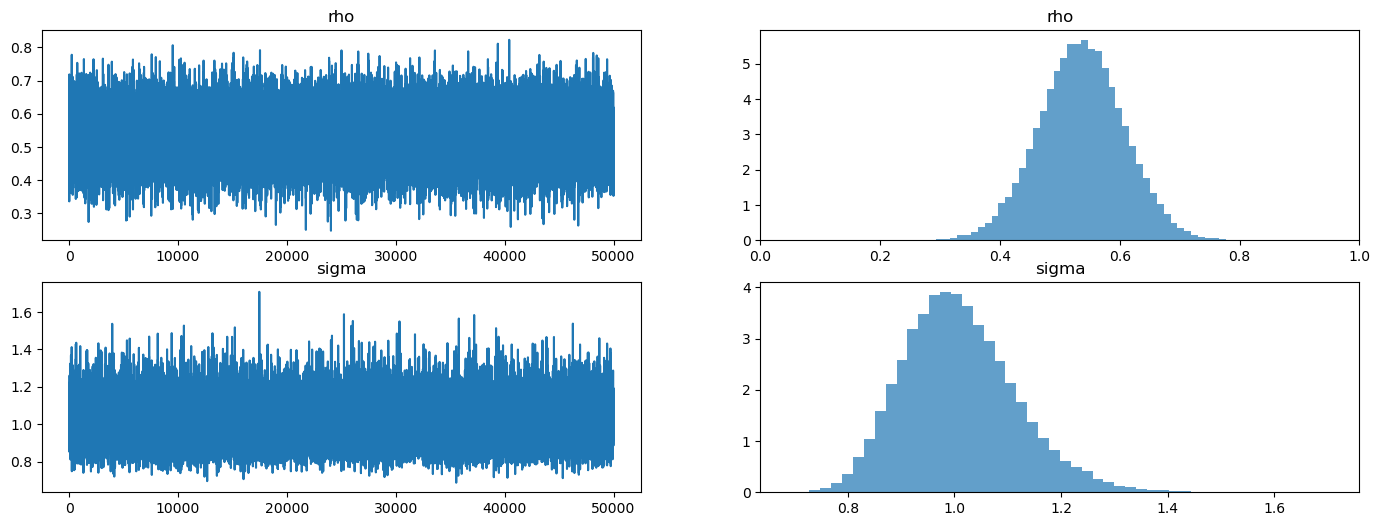

In [16]:
plot_posterior(mcmc.get_samples())

In [17]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       rho      0.54      0.07      0.54      0.42      0.65  31951.91      1.00
     sigma      1.01      0.11      1.00      0.84      1.18  32441.11      1.00

Number of divergences: 0


Next, we again compute the posterior under the assumption that $y_0$ is drawn from the stationary distribution, so that

$$
y_0 \sim N \left(0, \frac{\sigma_x^{2}}{1 - \rho^{2}} \right)
$$

Here's the new code to achieve this.

In [18]:
def AR1_model_y0(data):
    # Set prior
    rho = numpyro.sample('rho', dist.Uniform(low=-1., high=1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=np.sqrt(10)))

    # Standard deviation of ergodic y
    y_sd = sigma / jnp.sqrt(1 - rho**2)

    # Expected value of y at the next period (rho * y)
    yhat = rho * data[:-1]

    # Likelihood of the actual realization.
    y_data = numpyro.sample('y_obs', dist.Normal(loc=yhat, scale=sigma), obs=data[1:])
    y0_data = numpyro.sample('y0_obs', dist.Normal(loc=0., scale=y_sd), obs=data[0])

In [19]:
# Make jnp array
y = jnp.array(y)

# Set NUTS kernal
NUTS_kernel = numpyro.infer.NUTS(AR1_model_y0)

# Run MCMC
mcmc2 = numpyro.infer.MCMC(NUTS_kernel, num_samples=50000, num_warmup=10000, progress_bar=False)
mcmc2.run(rng_key=random.PRNGKey(1), data=y)

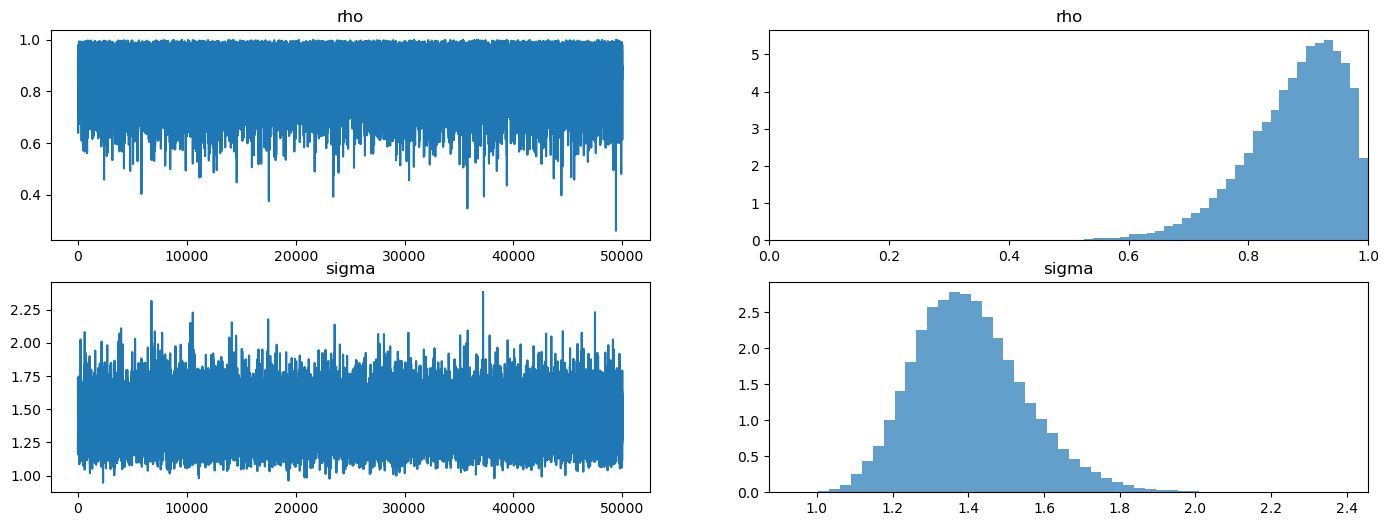

In [20]:
plot_posterior(mcmc2.get_samples())

In [21]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       rho      0.88      0.08      0.89      0.76      1.00  28934.75      1.00
     sigma      1.40      0.15      1.39      1.17      1.64  25034.29      1.00

Number of divergences: 0


Look what happened to the posterior!

It has moved far from the true values of the parameters used to generate the data because of how Bayes' Law (i.e., conditional probability)
is telling `numpyro` to explain what it interprets as  "explosive" observations early in the sample.

Bayes' Law is able to generate a plausible likelihood for the first observation by driving $\rho \rightarrow 1$ and $\sigma \uparrow$ in order to raise the variance of the stationary distribution.

Our example illustrates the importance of what you assume about the distribution of initial conditions.